## Protein in Water

*Solvating a protein structure from the PDB and running NPT dynamics*

### Introduction

This is the OpenMM version of [Justin A. Lemkul's Lysozyme in Water GROMACS tutorial](http://www.mdtutorials.com/gmx/lysozyme/index.html).

It will cover the following steps

- Load a PDB file into OpenMM
- Choose the force-field 
- Clean-up the file
- Solvate the protein with water and ions
- Setup system and integrator
- Run local minization
- Run NVT equilibration
- Run NPT production molecular dynamics
- Basic analysis.

### Download the protein structure file

First we need to download the PDB file of the lysozome from the RCSB Protein Data Bank https://www.rcsb.org/structure/1aki

In [1]:
!wget https://files.rcsb.org/download/1AKI.pdb

--2022-12-23 14:47:36--  https://files.rcsb.org/download/1AKI.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.66
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1AKI.pdb’

1AKI.pdb                [  <=>               ] 113.59K   456KB/s    in 0.2s    

2022-12-23 14:47:40 (456 KB/s) - ‘1AKI.pdb’ saved [116316]



### Load the PDB file into OpenMM

In [2]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

pdb = PDBFile("1AKI.pdb")


### Define the forcefield

We need to define the forcefield we want to use. We will use the Amber14 forcefield and the TIP3P-FB water model.

In [3]:
# Specify the forcefield 
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

### Clean up

This PDB file contains some crystal water molecules which we want to strip out. This can be done using the Modeller class.
We also add in any missing H atoms.

In [4]:
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
residues=modeller.addHydrogens(forcefield)

### Solvate

We can use the `addSolvent` method to add water molecules

In [5]:
modeller.addSolvent(forcefield, padding=1.0*nanometer)

This command creates a box that has edges at least 1nm away from the solute and fills it with water molecules. Addionally it adds in the required number of CL and Na ions to make the system charge neutral.

### Setup system and Integrator

We now need to combine our molecular topology and the forcefield to create a complete description of the system. This is done using the `ForceField` object's `createSystem()` function.
We then create the integrator, and combine the integrator and system to create the `Simulation` object. Finally we set the initial atomic positions.

In [6]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

### Local energy minimization

It is a good idea to run local energy minimization at the start of a simulation, since the coordinates in the PDB file might produce very large forces

In [7]:
print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


### Setup reporting 

To get output from our simulation we can add reporters. We use `PDBReporter` to write the coorinates every 1000 timesteps to "output.pdb" and we use `StateDataReporter` to print the timestep, potential energy, temperature, and volume to the screen and to a file called "md_log.txt".

In [8]:
simulation.reporters.append(PDBReporter('output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))
simulation.reporters.append(StateDataReporter("md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))

### NVT equillibration

We are using a Langevin integrator which means we are simulating in the NVT ensemble. To equilibrate the temperature we just need to run the simulation for a number of timesteps.

In [9]:
print("Running NVT")
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-361152.47182837734,290.59113263667587,237.5626678984939
2000,-358285.09682837734,302.79078945563003,237.5626678984939
3000,-358005.84682837734,302.48286620646525,237.5626678984939
4000,-358507.72182837734,298.6930169859535,237.5626678984939
5000,-358184.97182837734,299.2717701713331,237.5626678984939
6000,-358212.97182837734,300.75294253983,237.5626678984939
7000,-359764.59682837734,300.86799019463365,237.5626678984939
8000,-358504.22182837734,300.08571555582586,237.5626678984939
9000,-358743.72182837734,301.49754076972073,237.5626678984939
10000,-358427.47182837734,303.0196359235443,237.5626678984939


### NPT production MD

To run our simulation in the NPT ensemble we need to add in a barostat to control the pressure. We can use `MonteCarloBarostat`.

In [10]:
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)


print("Running NPT")
simulation.step(10000)

Running NPT
11000,-360868.2039845481,296.6271613599709,229.55243059554863
12000,-360440.69597966364,299.2972740816768,227.9584335998326
13000,-360306.2146281218,298.81725153096374,226.29494575252173
14000,-361092.9398954578,303.07884143773134,225.42478987487024
15000,-360441.3635788809,300.7599116506667,225.36581137758682
16000,-360902.0646238751,298.85839880440795,224.7134712811861
17000,-361590.4094829492,298.67191986774935,224.97738234573134
18000,-360249.67117970064,296.2367386071592,224.69872883856726
19000,-360755.6596395951,302.12766052941635,224.73491745579543
20000,-361129.44742261735,298.26462186445406,225.16297011700198


### Analysis

We can now do some basic analysis using Python. We will plot the time evolution of the potential energy, temperature, and box volume. Remember that OpenMM itself is primarly an MD engine, for in-depth anaylsis of your simulations you can use other python packages such as MDtraj, or MDAnalysis.

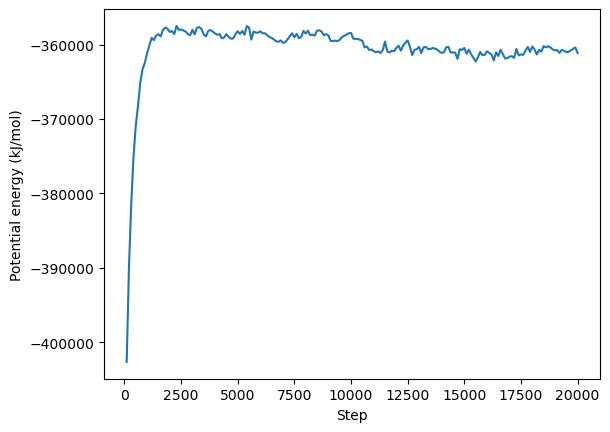

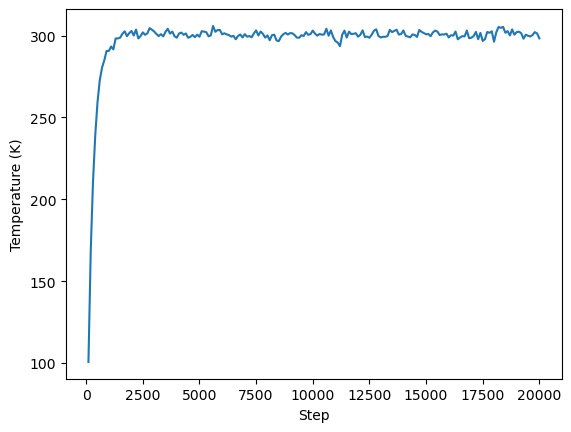

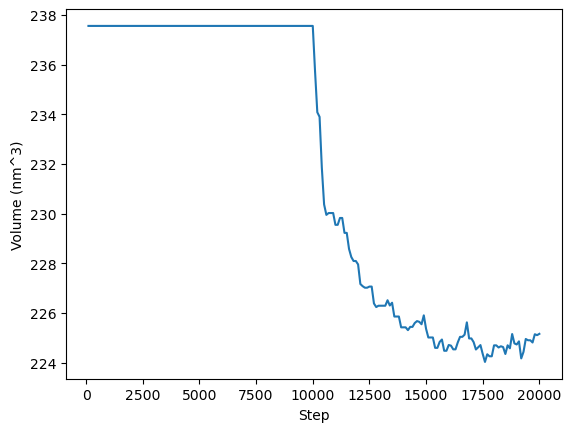

In [11]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt("md_log.txt", delimiter=',')

step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.show()

